In [1]:
from multiprocessing import Pool,sharedctypes
from functools import partial
from contextlib import closing
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import h5py as h5
import os
import sys
import skymapper as skm
import matplotlib.cm as cm
import matplotlib
import copy

In [3]:
def getHealpixCoords(pixels, nside, nest=False):
    # convert healpix cell indices to center ra/dec
    import healpy as hp
    theta, phi = hp.pix2ang(nside, pixels, nest=nest)
    return phi * 180. / np.pi, 90 - theta * 180. / np.pi


def log_skm_plot(mapa, mask, sep=15, ra = None, dec = None, richness = None, title = None, add_rmp = True, small_scale = False, cb_label = 'number density [n_gal/arcmin$^2$]', x_size = 6, y_size = 6, vmin = -0.01, vmax = 0.01):
    cmap = cm.RdYlBu_r
    fig = plt.figure(figsize=(x_size,y_size))
    ax = fig.add_subplot(111, aspect='equal')
       
    reticule = sep
    nside = hp.pixelfunc.npix2nside(len(mapa))
    pixels = np.array(range(len(mapa)))
    pixels = pixels[~mask]
    print(pixels)
    ra_, dec_ = getHealpixCoords(pixels, nside)

    # setup map: define AEA map optimal for given RA/Dec
    #proj = skm.createConicMap(ax, ra_, dec_, proj_class=skm.AlbersEqualAreaProjection)
    crit = skm.stdDistortion
    proj = skm.Albers.optimize(ra_, dec_, crit=crit)
    # add lines and labels for meridians/parallels (separation 5 deg)
    
    parallels = np.arange(0. ,360., reticule)
    meridians = np.arange(-90., 90., reticule)
    # convert to map coordinates and plot a marker for each point
    x,y = proj(ra_, dec_)
    marker = 's'
    #markersize = skm.getMarkerSizeToFill(fig, ax, x, y)
    #s=markersize,
    sc = ax.scatter(x,y, c=mapa[pixels], edgecolors='None', marker=marker, s=2,  cmap=cmap, vmin=vmin, vmax=vmax, rasterized=True, zorder=1,
                norm=matplotlib.colors.LogNorm())
    xlabels=ax.get_xticks()
    ylabels=ax.get_yticks()
    print(xlabels,ylabels)
    #ax.set_xticklabels(ra_,dec_)
    #ax.set_xticklabels(map(str, ax.get_xticks()/5.0))
    #labels=getHealpixCoords(labels, nside)
    #print(labels)

    # overplot with another data set
    # here clusters [not implemented]
    if add_rmp:
        x,y = proj(ra, dec)
        ax.scatter(x,y, c='None', edgecolors='k', linewidths=1, s=richness, marker='o', zorder=3)
    if title:
        plt.title(title)

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    
    cax = divider.append_axes("right", size="2%", pad=0.3)
    cb = fig.colorbar(sc, cax=cax )
    if cb_label != None:
        cb.set_label(cb_label)
    ticks = np.linspace(vmin, vmax, 5)
    cb.set_ticks(ticks)
    if small_scale:
        cb.set_ticklabels([('%.1f' % (t))   for t in ticks])       
    else:
        cb.set_ticklabels([('%.1f' % (t))   for t in ticks])
    cb.solids.set_edgecolor("face")
    fig.show()

    
def skm_plot(mapa, mask, sep=15, ra = None, dec = None, richness = None, title = None, add_rmp = True, small_scale = False, cb_label = 'number density [n_gal/arcmin$^2$]', x_size = 6, y_size = 6, vmin = -0.01, vmax = 0.01):
    cmap = cm.RdYlBu_r
    fig = plt.figure(figsize=(x_size,y_size))
    ax = fig.add_subplot(111, aspect='equal')
       
    reticule = sep
    nside = hp.pixelfunc.npix2nside(len(mapa))
    pixels = np.array(range(len(mapa)))
    pixels = pixels[~mask]
    ra_, dec_ = getHealpixCoords(pixels, nside)

    # setup map: define AEA map optimal for given RA/Dec
    crit = skm.stdDistortion
    proj = skm.Albers.optimize(ra_, dec_, crit=crit)
    # add lines and labels for meridians/parallels (separation 5 deg)
    
    parallels = np.arange(0. ,360., reticule)
    meridians = np.arange(-90., 90., reticule)
    # convert to map coordinates and plot a marker for each point
    x,y = proj(ra_, dec_)
    marker = 's'

    sc = ax.scatter(x,y, c=mapa[pixels], edgecolors='None', marker=marker, s=2,  cmap=cmap, vmin=vmin, vmax=vmax, rasterized=True, zorder=1)

    # overplot with another data set
    if add_rmp:
        x,y = proj(ra, dec)
        ax.scatter(x,y, c='None', edgecolors='k', linewidths=1, s=richness, marker='o', zorder=3)
    if title:
        plt.title(title)

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    
    cax = divider.append_axes("right", size="2%", pad=0.3)
    cb = fig.colorbar(sc, cax=cax )
    if cb_label != None:
        cb.set_label(cb_label)
    ticks = np.linspace(vmin, vmax, 5)
    cb.set_ticks(ticks)
    if small_scale:
        cb.set_ticklabels([('%.1f' % (t))   for t in ticks])       
    else:
        cb.set_ticklabels([('%.1f' % (t))   for t in ticks])
    cb.solids.set_edgecolor("face")
    fig.show()


bins = ['all']
nside = 1024
def convert_to_pix_coord(ra, dec, nside=1024):
    """
    Converts RA,DEC to hpix coordinates
    """
    theta = (90.0 - dec) * np.pi / 180.
    phi = ra * np.pi / 180.
    pix = hp.ang2pix(nside, theta, phi, nest=False)
    return pix
print ('done' )


done


# Read data

In [4]:
import yaml
import destest
import treecorr


# basic dict props
destest_dict_ = {
    'output_exists' : True,
    'use_mpi'       : False,
    'source'        : 'hdf5',
    'dg'            : 0.01
    }

# Populates a full destest yaml dict for each catalog selection based on the limited catalog input info provided in the common cats.yaml file
def create_destest_yaml( params, name, cal_type, group, table, select_path ):
    """
    Creates the input dictionary structure from a passed dictionary rather than reading froma yaml file.
    """

    destest_dict = destest_dict_.copy()
    destest_dict['load_cache'] = params['load_cache']
    destest_dict['output'] = params['output']
    destest_dict['name'] = name
    destest_dict['filename'] = params['datafile']
    destest_dict['param_file'] = params['param_file']
    destest_dict['cal_type'] = cal_type
    destest_dict['group'] = group
    destest_dict['table'] = table
    destest_dict['select_path'] = select_path
    destest_dict['e'] = ['e_1','e_2']
    destest_dict['Rg'] = ['R11','R22']
    destest_dict['w'] = 'weight'

    return destest_dict

# Build selector (and calibrator) classes from destest for the catalog.
def load_catalog(pipe_params, name, cal_type, group, table, select_path, inherit=None, return_calibrator=None):
    """
    Loads data access and calibration classes from destest for a given yaml setup file.
    """

    # Input yaml file defining catalog
    params = create_destest_yaml(pipe_params, name, cal_type, group, table, select_path)

    # Load destest source class to manage access to file
    source = destest.H5Source(params)

    # Load destest selector class to manage access to data in a structured way
    if inherit is None:
        sel = destest.Selector(params,source)
    else:
        sel = destest.Selector(params,source,inherit=inherit)

    # Load destest calibrator class to manage calibration of the catalog
    if return_calibrator is not None:
        cal = return_calibrator(params,sel)
        return sel, cal
    else:
        return sel

# Read yaml file that defines all the catalog selections used
params = yaml.load(open('cats.yaml'))
params['param_file'] = 'cats.yaml'

# Source catalog
source_selector, source_calibrator = load_catalog(
    params, 'mcal', 'mcal', params['source_group'], params['source_table'], params['source_path'], return_calibrator=destest.MetaCalib)

# Gold catalog
gold_selector = load_catalog(
    params, 'gold', 'mcal', params['gold_group'], params['gold_table'], params['gold_path'], inherit=source_selector)
# BPZ (or DNF) catalog, depending on paths in cats.yaml file (exchange bpz and dnf)
pz_selector = load_catalog(
    params, 'pz', 'mcal', params['pz_group'], params['pz_table'], params['pz_path'], inherit=source_selector)


R1,c,w = source_calibrator.calibrate('e_1') # Optionally pass an additional mask to use when calculating the selection response. The returned R1 is <Rg_1 + Rs_1>. To get an array of R's, use return_wRg=True to get [Rg_1+Rg_2]/2 for each object or return_wRgS=True to include the selection response. return_full=True returns the non-component-averaged version of the full response.
print(R1,c,w)
R2,c,w = source_calibrator.calibrate('e_2')
print(R2,c,w)


# Load ra,dec from gold catalog
ra  = gold_selector.get_col('ra')[0]
dec = gold_selector.get_col('dec')[0]

# Get e1,e2 
g1=source_selector.get_col('e_1')[0]
g2=source_selector.get_col('e_2')[0]
snr =source_selector.get_col('snr')[0]
size_ratio =source_selector.get_col('size_ratio')[0]
w = source_calibrator.calibrate('e_1',weight_only=True) # Optionally pass an additional mask to use when calculating the selection response. The returned R1 is <Rg_1 + Rs_1>. To get an array of R's, use return_wRg=True to get [Rg_1+Rg_2]/2 for each object or return_wRgS=True to include the selection response. return_full=True returns the non-component-averaged version of the full response.

g1 =(g1 - np.mean(g1*w)/np.mean(w))/R1
g2 =(g2 - np.mean(g2*w)/np.mean(w))/R2


/global/homes/m/mgatti/.conda/envs/py3s/lib/python3.6/site-packages/ipykernel_launcher.py:62: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


['T', 'T_err', 'covmat_0_1', 'covmat_1_1', 'covmat_2_2', 'e_1', 'e_2', 'flux_err_i', 'flux_err_r', 'flux_err_z', 'flux_i', 'flux_r', 'flux_z', 'size_ratio', 'snr', 'weight']
using select_path for mask
destest /global/cscratch1/sd/troxel/cats_des_y3/Y3_mastercat_03_31_20.h5 index/select 399263026 100202538
end mask [     7390      7391      7393 ... 399243228 399243235 399243240] [ True  True  True ...  True  True  True]
R11 not in sheared cols
R11 not in sheared cols
R11 not in sheared cols
R11 not in sheared cols
R22 not in sheared cols
R22 not in sheared cols
R22 not in sheared cols
R22 not in sheared cols
skipping sheared columns for e_1
skipping sheared columns for e_1
skipping sheared columns for e_1
skipping sheared columns for e_1
skipping sheared columns for e_2
skipping sheared columns for e_2
skipping sheared columns for e_2
skipping sheared columns for e_2
['bhat', 'cell_wide']
----- e_1 ['e_1', 'e_2']
Rs e_1 0.6735345990167841 0.009031119283563331
0.7176500844536258 0.0 [32

# n_eff

n_eff:  5.848186129661877
optimizing parameters of Albers to minimize stdDistortion
best objective 0.046034 at Albers(25.17718419149722,-35.86924773198294,-57.24009737354554,-11.318617719911941)


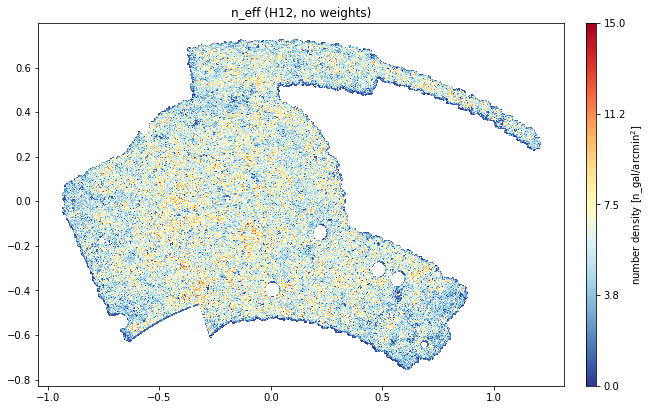

/global/homes/m/mgatti/.conda/envs/py3s/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


n_eff:  4.889722929629935
optimizing parameters of Albers to minimize stdDistortion
best objective 0.046034 at Albers(25.17718419149722,-35.86924773198294,-57.24009737354554,-11.318617719911941)


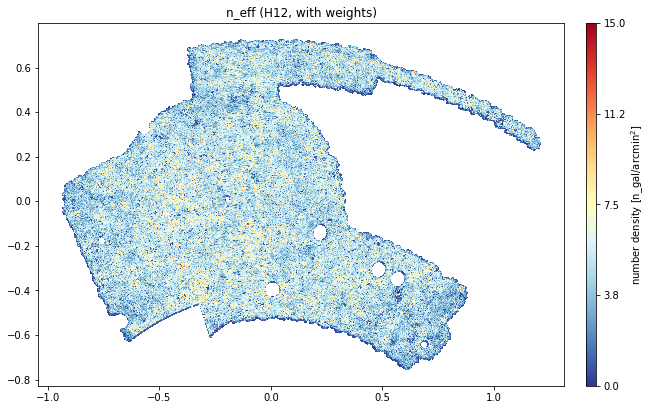

In [9]:
%matplotlib inline
sizz = 10 # size plots 

if not os.path.exists('./figures_maps/'):
    os.mkdir('./figures_maps/')
#neff map ******************
desy3_map = np.zeros(hp.nside2npix(nside))
pix1 = convert_to_pix_coord(ra,dec, nside=nside)

unique_pix1, idx1, idx_rep1 = np.unique(pix1, return_index=True, return_inverse=True)
desy3_map[unique_pix1] += np.bincount(idx_rep1, weights=np.ones(len(pix1)))
mas_desy3 = desy3_map!=0.
res = desy3_map/(hp.pixelfunc.nside2pixarea(nside,degrees=True)*(60*60)) #/R_ave
print ('n_eff: ',np.mean(res[mas_desy3]))
skm_plot(res, ~mas_desy3 , sep=15 , title = 'n_eff (H12, no weights)',add_rmp=False, ra = [], dec = [], richness = [], x_size = sizz, y_size = sizz, vmin = 0, vmax = 15,small_scale='True')
plt.savefig('./figures_maps/number_density.pdf')
plt.show()

#neff map with weights ******************

# def heymans: 1/Area sum(w)**2 / sum (w**2)
desy3_map_w = np.zeros(hp.nside2npix(nside))
desy3_map_w2 = np.zeros(hp.nside2npix(nside))

pix1 = convert_to_pix_coord(ra,dec, nside=nside)

unique_pix1, idx1, idx_rep1 = np.unique(pix1, return_index=True, return_inverse=True)
desy3_map_w[unique_pix1] += np.bincount(idx_rep1, weights=w)
desy3_map_w2[unique_pix1] += np.bincount(idx_rep1, weights=w**2)

res_w = desy3_map_w**2/desy3_map_w2/(hp.pixelfunc.nside2pixarea(nside,degrees=True)*(60*60)) #/R_ave
print( 'n_eff: ',np.mean(res_w[mas_desy3]))
skm_plot(res_w, ~mas_desy3 , sep=15 , title = 'n_eff (H12, with weights)',add_rmp=False, ra = [], dec = [], richness = [], x_size = sizz, y_size = sizz, vmin = 0, vmax = 15,small_scale='True')
plt.savefig('./figures_maps/number_density_H12.pdf')
plt.show()

# weight

32.80541579578434
[ 5695852  5695853  5695854 ... 12117619 12117620 12117621]
optimizing parameters of Albers to minimize stdDistortion
best objective 0.046034 at Albers(25.17718419149722,-35.86924773198294,-57.24009737354554,-11.318617719911941)
[-1.5 -1.  -0.5  0.   0.5  1.   1.5] [-1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8]


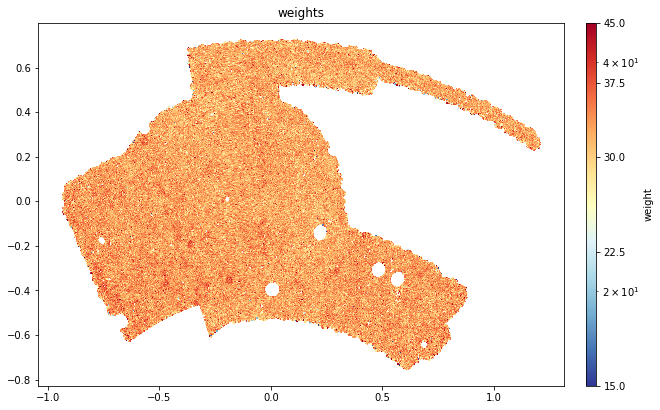

In [10]:
sizz = 10 # size plots 

w_map = np.zeros(hp.nside2npix(nside))
pix1 = convert_to_pix_coord(ra,dec, nside=nside)
unique_pix1, idx1, idx_rep1 = np.unique(pix1, return_index=True, return_inverse=True)
w_map[unique_pix1] += np.bincount(idx_rep1, weights=w)

mas_desy3 = desy3_map!=0.
w_map[mas_desy3] = w_map[mas_desy3]/desy3_map[mas_desy3]
print(np.mean(w_map[mas_desy3]))
log_skm_plot(w_map, ~mas_desy3 , sep=15 , title = 'weights',add_rmp=False, ra = [], dec = [], richness = [], x_size = sizz, y_size = sizz, cb_label = 'weight', vmin = 15, vmax = 45,small_scale='True')
plt.savefig('./figures_maps/weight.pdf')

# snr

In [11]:
sizz = 10 # size plots 

# snr with weights ******************

snr_map_w = np.zeros(hp.nside2npix(nside))
pix1 = convert_to_pix_coord(ra,dec, nside=nside)
unique_pix1, idx1, idx_rep1 = np.unique(pix1, return_index=True, return_inverse=True)
snr_map_w[unique_pix1] += np.bincount(idx_rep1, weights=snr*w)

mas_desy3 = desy3_map!=0.
snr_map_w[mas_desy3] = snr_map_w[mas_desy3]/desy3_map_w[mas_desy3]
print(np.mean(snr_map_w[mas_desy3]))
log_skm_plot(snr_map_w, ~mas_desy3 , sep=15 , title = 'SNR (with weights)',add_rmp=False, ra = [], dec = [], richness = [], x_size = sizz, y_size = sizz, cb_label = 'SNR', vmin = 20, vmax = 100,small_scale='True')
plt.savefig('./figures_maps/snr_with_weights.pdf')

plt.show()
# snr ******************

snr_map = np.zeros(hp.nside2npix(nside))
pix1 = convert_to_pix_coord(rra,dec, nside=nside)
unique_pix1, idx1, idx_rep1 = np.unique(pix1, return_index=True, return_inverse=True)
snr_map[unique_pix1] += np.bincount(idx_rep1, weights=snr)

mas_desy3 = desy3_map!=0.
snr_map[mas_desy3] = snr_map[mas_desy3]/desy3_map[mas_desy3]
print(np.mean(snr_map[mas_desy3]))
log_skm_plot(snr_map, ~mas_desy3 , sep=15 , title = 'SNR (no weights)',add_rmp=False, ra = [], dec = [], richness = [], x_size = sizz, y_size = sizz, cb_label = 'SNR', vmin = 20, vmax = 100,small_scale='True')
plt.savefig('./figures_maps/snr.pdf')





NameError: name 'snr' is not defined

# size ratio

In [ ]:
sizz = 10 # size plots 


# Size ratio  (now made with psf_T) ****************************

SR_map = np.zeros(hp.nside2npix(nside))
pix1 = convert_to_pix_coord(ra,dec, nside=nside)
unique_pix1, idx1, idx_rep1 = np.unique(pix1, return_index=True, return_inverse=True)
SR_map[unique_pix1] += np.bincount(idx_rep1, weights=size_ratio)

mas_desy3 = desy3_map!=0.
SR_map[mas_desy3] = SR_map[mas_desy3]/desy3_map[mas_desy3]
print(np.mean(SR_map[mas_desy3]))
log_skm_plot(SR_map, ~mas_desy3 , sep=15 , title = 'size ratio (no weights)',add_rmp=False, ra = [], dec = [], richness = [], x_size = sizz, y_size = sizz, cb_label = 'size ratio', vmin = 0.5, vmax = 2.5,small_scale='True')
plt.savefig('./figures_maps/SR.pdf')


# Size ratio  with weights (now made with psf_T) ****************************


SR_map_w = np.zeros(hp.nside2npix(nside))
pix1 = convert_to_pix_coord(ra,dec, nside=nside)
unique_pix1, idx1, idx_rep1 = np.unique(pix1, return_index=True, return_inverse=True)
SR_map_w [unique_pix1] += np.bincount(idx_rep1, weights=(size_ratio*w))

mas_desy3 = desy3_map!=0.
SR_map_w[mas_desy3] = SR_map_w[mas_desy3]/desy3_map_w[mas_desy3]
print(np.mean(SR_map_w[mas_desy3]))
log_skm_plot(SR_map_w, ~mas_desy3 , sep=15 , title = 'size ratio (with weights)',add_rmp=False, ra = [], dec = [], richness = [], x_size = sizz, y_size = sizz, cb_label = 'size ratio', vmin = 0.5, vmax = 2.5,small_scale='True')
plt.savefig('./figures_maps/SR_with_weights.pdf')

1.3502141223616866
[ 5695852  5695853  5695854 ... 12117619 12117620 12117621]
optimizing parameters of Albers to minimize stdDistortion
best objective 0.046034 at Albers(25.17718419149722,-35.86924773198294,-57.24009737354554,-11.318617719911941)
[-1.5 -1.  -0.5  0.   0.5  1.   1.5] [-1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8]


# sigma_e

In [ ]:
sum_we2_2 = np.zeros(hp.nside2npix(nside))
sum_we2_1 = np.zeros(hp.nside2npix(nside))
sum_w2 = np.zeros(hp.nside2npix(nside))
sum_w = np.zeros(hp.nside2npix(nside))



pix1 = convert_to_pix_coord(ra,dec, nside=nside)
unique_pix1, idx1, idx_rep1 = np.unique(pix1, return_index=True, return_inverse=True)

sum_we2_2[unique_pix1] += np.bincount(idx_rep1, weights=(w*g2)**2)
sum_we2_1[unique_pix1] += np.bincount(idx_rep1, weights=(w*g1)**2)
sum_w2[unique_pix1] += np.bincount(idx_rep1, weights=(w)**2)
sum_w[unique_pix1] += np.bincount(idx_rep1, weights=(w))


sig_e = np.sqrt((sum_we2_1/sum_w**2+sum_we2_2/sum_w**2)*(sum_w**2/sum_w2)/2.)
#sig_ec = np.sqrt((sum_we2_1/sum_w**2+sum_we2_2/sum_w**2)*(sum_w**2/sum_w2)/2.)
print (np.mean(sig_e[mas_desy3]))
skm_plot(sig_e, ~mas_desy3 , sep=15 , title = 'sigma_e (with weights)',add_rmp=False, ra = [], dec = [], richness = [], x_size = sizz, y_size = sizz, cb_label = 'sigma_e', vmin = 0.3, vmax = 0.5,small_scale='True')
plt.savefig('./figures_maps/sigma_e_weights.pdf')
plt.show()


sum_we2_2 = np.zeros(hp.nside2npix(nside))
sum_we2_1 = np.zeros(hp.nside2npix(nside))
sum_w2 = np.zeros(hp.nside2npix(nside))
sum_w = np.zeros(hp.nside2npix(nside))



pix1 = convert_to_pix_coord(ra,dec, nside=nside)
unique_pix1, idx1, idx_rep1 = np.unique(pix1, return_index=True, return_inverse=True)

sum_we2_2[unique_pix1] += np.bincount(idx_rep1, weights=(g2)**2)
sum_we2_1[unique_pix1] += np.bincount(idx_rep1, weights=(g1)**2)
sum_w2[unique_pix1] += np.bincount(idx_rep1, weights=np.ones(len(g1)))
sum_w[unique_pix1] += np.bincount(idx_rep1, weights=np.ones(len(g1)))

sig_e = np.sqrt((sum_we2_1/sum_w**2+sum_we2_2/sum_w**2)*(sum_w**2/sum_w2)/2.)
#sig_ec = np.sqrt((sum_we2_1/sum_w**2+sum_we2_2/sum_w**2)*(sum_w**2/sum_w2)/2.)
print (np.mean(sig_e[mas_desy3]))
skm_plot(sig_e, ~mas_desy3 , sep=15 , title = 'sigma_e (no weights)',add_rmp=False, ra = [], dec = [], richness = [], x_size = sizz, y_size = sizz, cb_label = 'sigma_e', vmin = 0.3, vmax = 0.5,small_scale='True')
plt.savefig('./figures_maps/sigma_e.pdf')




# mean e1,e2

optimizing parameters of Albers to minimize stdDistortion
best objective 0.046034 at Albers(25.98675723800992,-35.86924773198294,-57.27828260783114,-11.344402695166536)


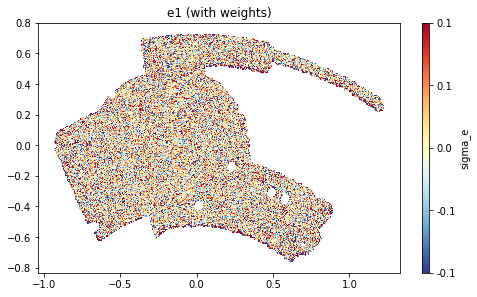

optimizing parameters of Albers to minimize stdDistortion
best objective 0.046034 at Albers(25.98675723800992,-35.86924773198294,-57.27828260783114,-11.344402695166536)


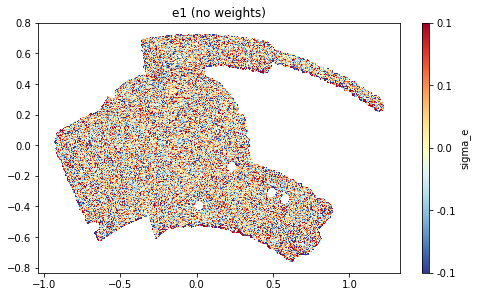

optimizing parameters of Albers to minimize stdDistortion
best objective 0.046034 at Albers(25.98675723800992,-35.86924773198294,-57.27828260783114,-11.344402695166536)


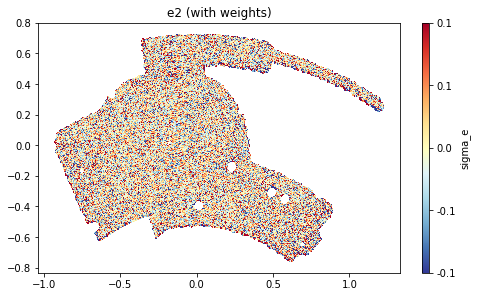

optimizing parameters of Albers to minimize stdDistortion
best objective 0.046034 at Albers(25.98675723800992,-35.86924773198294,-57.27828260783114,-11.344402695166536)


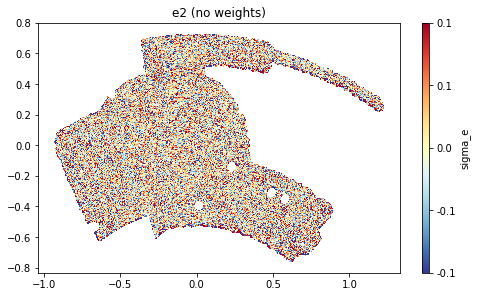

In [60]:
e1_map = np.zeros(hp.nside2npix(nside))
e1_map_w = np.zeros(hp.nside2npix(nside))
e2_map = np.zeros(hp.nside2npix(nside))
e2_map_w = np.zeros(hp.nside2npix(nside))

pix1 = convert_to_pix_coord(ra,dec, nside=nside)
unique_pix1, idx1, idx_rep1 = np.unique(pix1, return_index=True, return_inverse=True)
e1_map_w[unique_pix1] += np.bincount(idx_rep1, weights=g1*w)
e2_map_w[unique_pix1] += np.bincount(idx_rep1, weights=g2*w)
e1_map[unique_pix1] += np.bincount(idx_rep1, weights=g1)
e2_map[unique_pix1] += np.bincount(idx_rep1, weights=g2)

mas_desy3 = desy3_map!=0.
e1_map_w[mas_desy3]=e1_map_w[mas_desy3]/desy3_map_w[mas_desy3]
e2_map_w[mas_desy3]=e2_map_w[mas_desy3]/desy3_map_w[mas_desy3]
e1_map[mas_desy3]  =e1_map[mas_desy3]/desy3_map[mas_desy3]
e2_map[mas_desy3]  =e2_map[mas_desy3]/desy3_map[mas_desy3]


skm_plot(e1_map_w, ~mas_desy3 , sep=15 , title = 'e1 (with weights)',add_rmp=False, ra = [], dec = [], richness = [], x_size = sizz, y_size = sizz, cb_label = 'sigma_e', vmin = -0.1, vmax = 0.1,small_scale='True')
plt.savefig('./figures_maps/e1_weights.pdf')
plt.show()

skm_plot(e1_map, ~mas_desy3 , sep=15 , title = 'e1 (no weights)',add_rmp=False, ra = [], dec = [], richness = [], x_size = sizz, y_size = sizz, cb_label = 'sigma_e', vmin = -0.1, vmax = 0.1,small_scale='True')
plt.savefig('./figures_maps/e1.pdf')
plt.show()


skm_plot(e2_map_w, ~mas_desy3 , sep=15 , title = 'e2 (with weights)',add_rmp=False, ra = [], dec = [], richness = [], x_size = sizz, y_size = sizz, cb_label = 'sigma_e', vmin = -0.1, vmax = 0.1,small_scale='True')
plt.savefig('./figures_maps/e2_weights.pdf')
plt.show()

skm_plot(e1_map, ~mas_desy3 , sep=15 , title = 'e2 (no weights)',add_rmp=False, ra = [], dec = [], richness = [], x_size = sizz, y_size = sizz, cb_label = 'sigma_e', vmin = -0.1, vmax = 0.1,small_scale='True')
plt.savefig('./figures_maps/e2.pdf')
plt.show()


# R Map

In [ ]:
#R map 

# compute response:  **********************
dgamma = 2. * 0.01
R11_1_metacal_a = ((e1p[select_metacal]) - (e1m[select_metacal]) + (
e1[select_metacal_1p]) - (
e1[select_metacal_1m]))/ dgamma
R22_1_metacal_a = ((e2p[select_metacal]) - (e2m[select_metacal]) + (
e2[select_metacal_2p]) - (
e2[select_metacal_2m])) / dgamma


R11_1_all_a = ((e1p[select_all]) - (e1m[select_all]) + (
e1[select_all_1p]) - (
e1[select_all_1m]))/ dgamma
R22_1_all_a = ((e2p[select_all]) - (e2m[select_all]) + (
e2[select_all_2p]) -(
e2[select_all_2m])) / dgamma




In [51]:
# add Y1 and SV outlines 